In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import regex as re
from datetime import datetime
from tqdm import tqdm
import pickle
import scipy
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss

import warnings
from tensorflow_addons.metrics import F1Score
from sklearn.utils.extmath import randomized_svd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding, LSTM, Flatten, Concatenate, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from prettytable import PrettyTable
from keras.models import load_model



warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

In [48]:
import gensim
from gensim.models import Word2Vec

In [49]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [50]:
customers_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_customers_dataset.csv")
geolocation_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_geolocation_dataset.csv")
order_items_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_order_items_dataset.csv")
order_payments_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_order_payments_dataset.csv")
order_reviews_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_order_reviews_dataset.csv")
orders_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_orders_dataset.csv")
products_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_products_dataset.csv")
sellers_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv(r"C:\Users\DELL\Downloads\archive (1)\product_category_name_translation.csv")

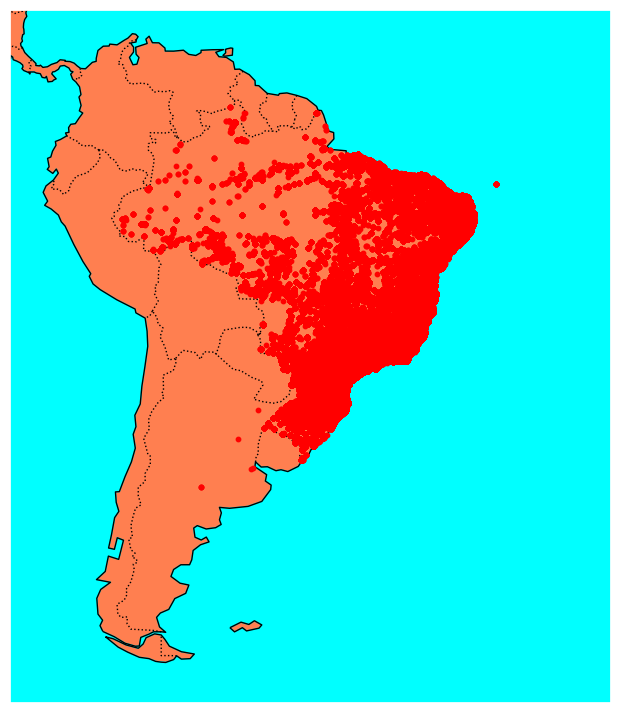

In [51]:
latitudes = geolocation_dataset['geolocation_lat'].values
longitudes = geolocation_dataset['geolocation_lng'].values

# Create a figure and axis with a specific projection
plt.figure(figsize=(14, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent([-85, -20, -60, 15], crs=ccrs.PlateCarree())

# Add coastlines and countries
ax.coastlines()
ax.add_feature(cfeature.LAND, color='coral')
ax.add_feature(cfeature.OCEAN, color='aqua')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the scatter points
plt.scatter(longitudes, latitudes, color='red', s=10, transform=ccrs.PlateCarree(), zorder=2)

# Show the plot
plt.show()

In [52]:
order_items_products = pd.merge(order_items_dataset,products_dataset,on='product_id')
order_items_products_sellers = pd.merge(order_items_products,sellers_dataset,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,orders_dataset,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,customers_dataset,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,order_reviews_dataset,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,order_payments_dataset,on='order_id')

In [53]:
mapping = dict(zip(product_category_name_translation['product_category_name'].tolist(),product_category_name_translation['product_category_name_english'].tolist()))
final_dataframe['product_category_name'] = final_dataframe['product_category_name'].map(mapping)

In [54]:
final_dataframe.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23


In [55]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(117329, 39)

In [56]:
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(101878, 39)

In [57]:
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [58]:
final_dataframe.dropna(subset=['shipping_limit_date','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], inplace=True)

In [59]:
intermediate_time = final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_purchase_timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['purchase-delivery difference'] = intermediate_time.apply(lambda x:x.days)

intermediate_time = final_dataframe['order_estimated_delivery_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['estimated-actual delivery difference'] = intermediate_time.apply(lambda x:x.days)

In [60]:
final_dataframe.isnull().sum()

order_item_id                               0
shipping_limit_date                         0
price                                       0
freight_value                               0
product_category_name                    1416
product_name_lenght                      1396
product_description_lenght               1396
product_photos_qty                       1396
product_weight_g                           16
product_length_cm                          16
product_height_cm                          16
product_width_cm                           16
seller_zip_code_prefix                      0
seller_city                                 0
seller_state                                0
customer_id                                 0
order_status                                0
order_purchase_timestamp                    0
order_approved_at                          14
order_delivered_carrier_date                0
order_delivered_customer_date               0
order_estimated_delivery_date     

In [61]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

In [62]:
final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

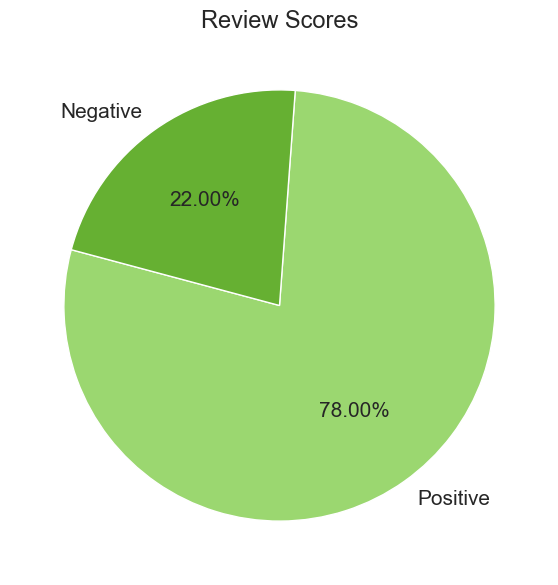

In [63]:
plt.figure(figsize=(7,7))
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=['#9BD770','#66B032','#f6b48f'])
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

In [64]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']].describe().round(3)

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000
mean,123.530,20.061,49.051,783.597,2082.759,30.062,16.357,23.024
std,186.164,15.763,9.977,645.221,3736.407,16.054,13.264,11.724
min,0.850,0.000,5.000,4.000,0.000,7.000,2.000,6.000
25%,40.000,13.140,43.000,348.000,300.000,18.000,8.000,15.000
50%,78.000,16.320,52.000,602.000,683.000,25.000,13.000,20.000
75%,139.000,21.180,57.000,980.000,1800.000,38.000,20.000,30.000
max,6735.000,409.680,76.000,3992.000,40425.000,105.000,105.000,118.000


In [65]:
final_dataframe['price_category'] = final_dataframe['price'].apply(lambda x:'expensive' if x>=139 else ('affordable' if x>=40 and x<139 else 'cheap'))

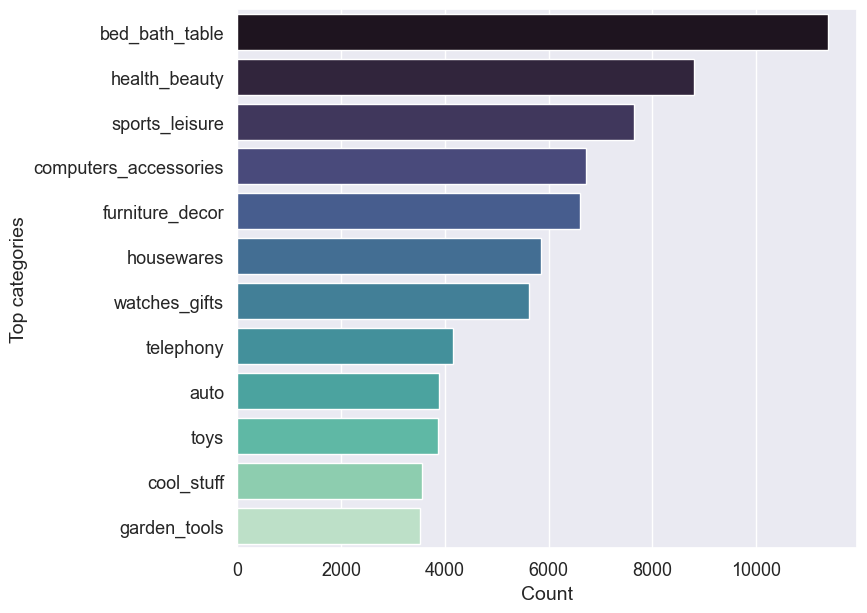

In [66]:
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:12].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="mako")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

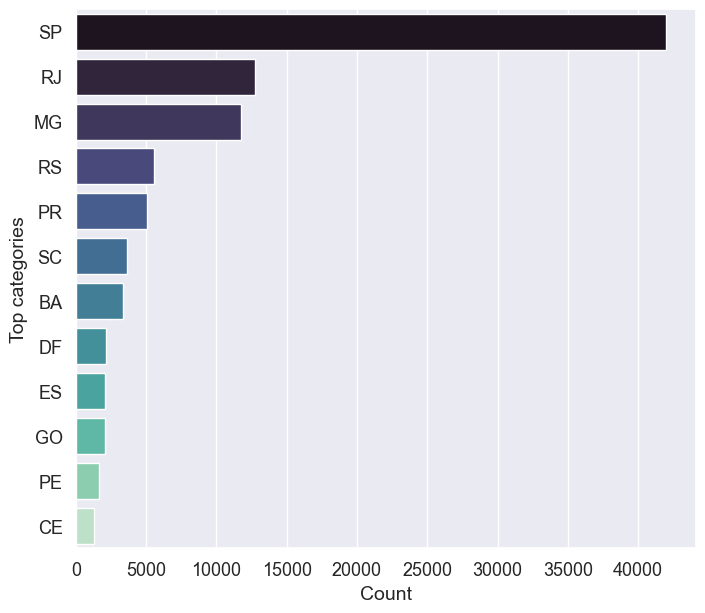

In [67]:
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:12].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="mako")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

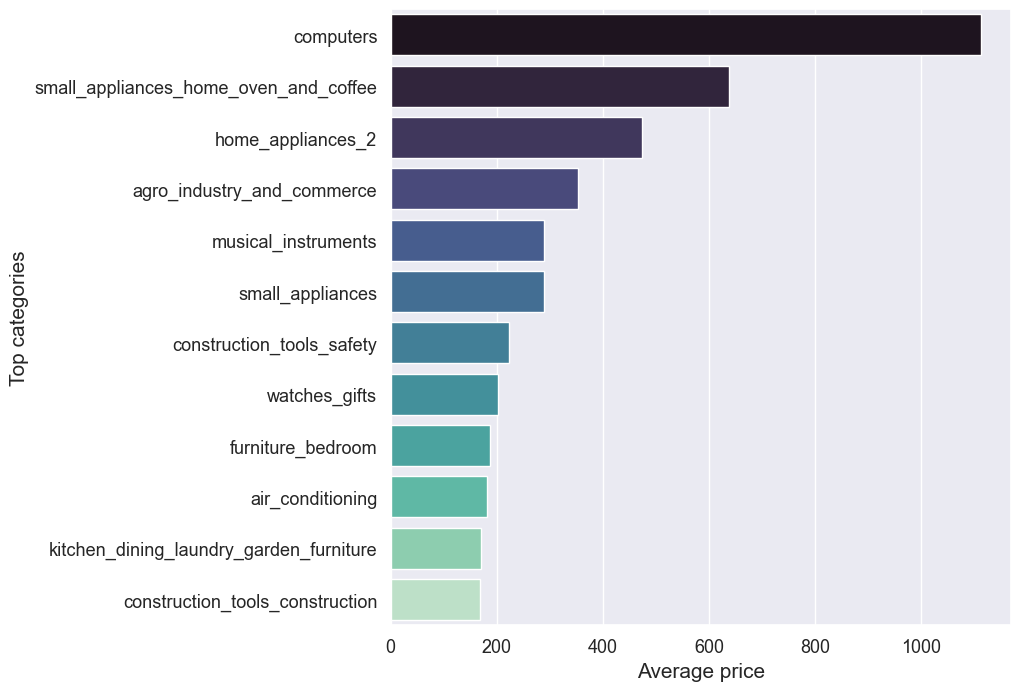

In [68]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="mako")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()


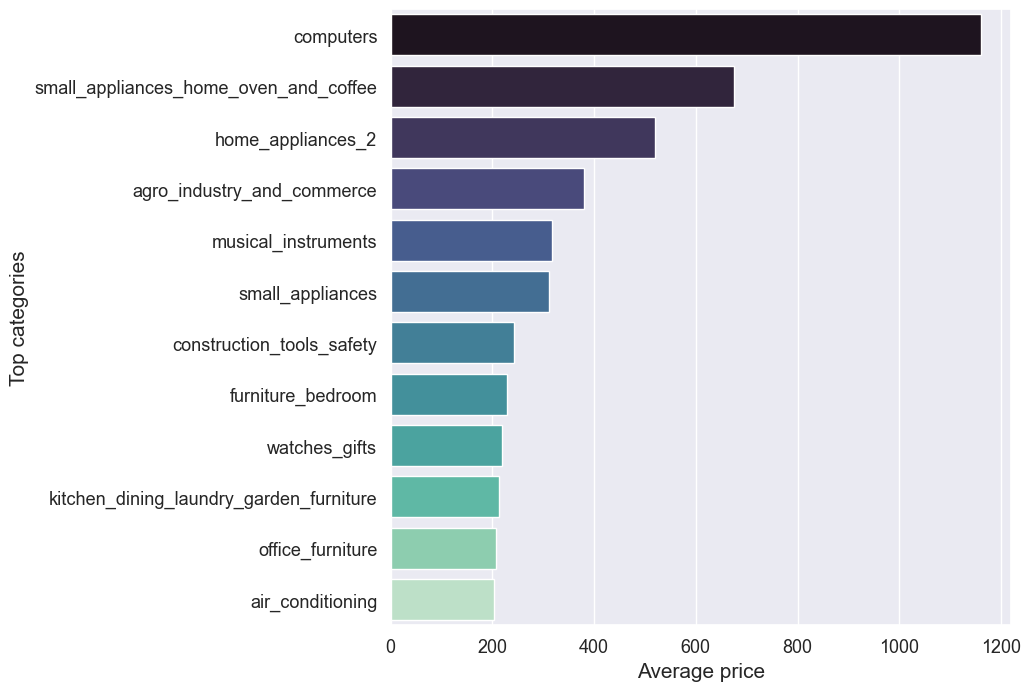

In [69]:
grp_dict = dict((grp_cat_name.mean()['price']+grp_cat_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="mako")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

In [70]:
final_dataframe['order_status'].value_counts()

delivered    99734
canceled         7
Name: order_status, dtype: int64

In [71]:
final_dataframe = final_dataframe[final_dataframe['order_status'] != 'canceled']

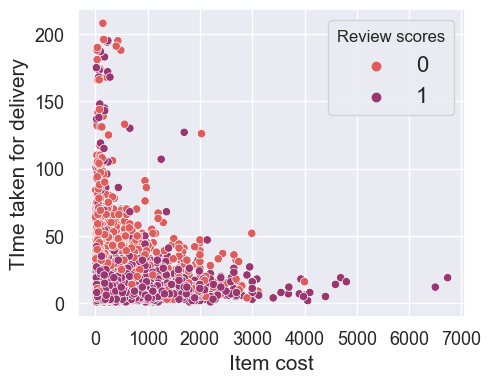

In [72]:
plt.figure(figsize=(5,4))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['purchase-delivery difference'],hue=final_dataframe['review_score'],palette="flare")
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('TIme taken for delivery', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [73]:
final_dataframe['purchase_delivery_diff_per_price'] = final_dataframe['purchase-delivery difference']/final_dataframe['price']

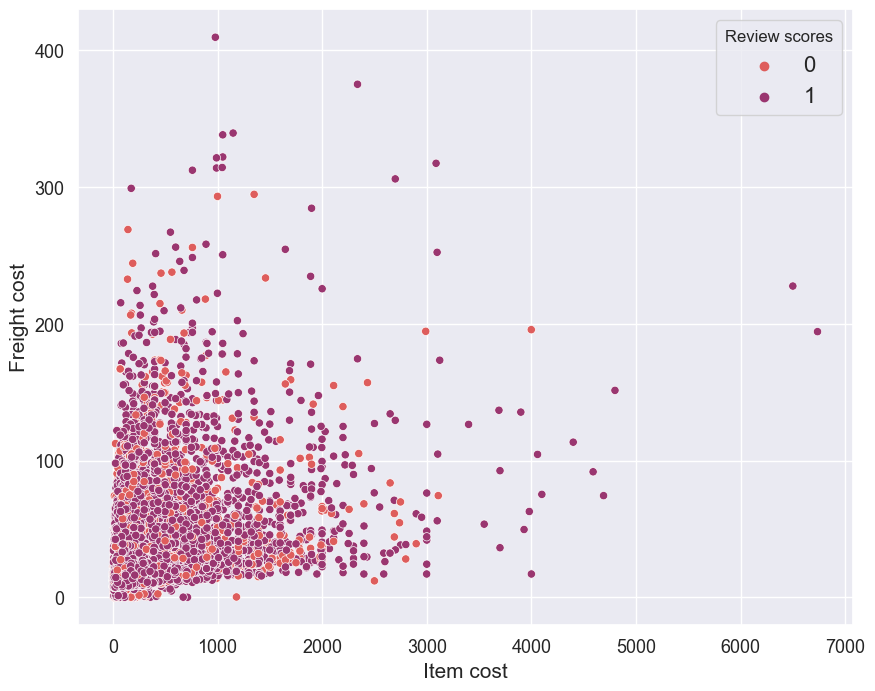

In [74]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['freight_value'],hue=final_dataframe['review_score'], palette='flare')
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('Freight cost', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

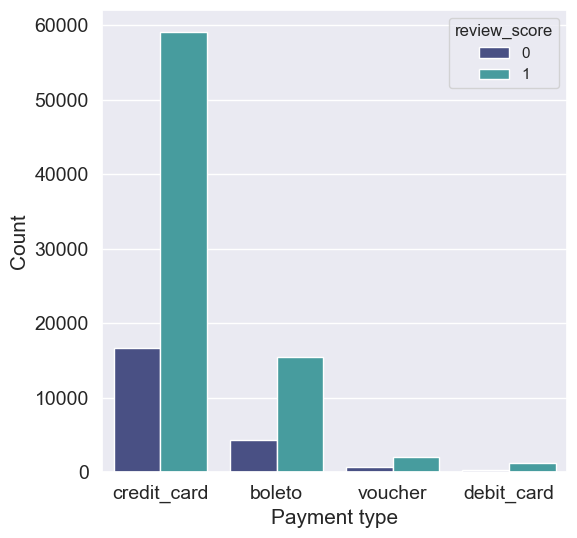

In [75]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='mako')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [76]:
final_dataframe.drop(['shipping_limit_date','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','customer_id'], axis=1, inplace=True)

In [77]:
labels = final_dataframe['review_score']
final_dataframe.drop('review_score', axis=1, inplace=True)

In [78]:
final_dataframe['review_availability'] = final_dataframe['review_comment_message'].apply(lambda x: 1 if x != 'indisponível' else 0)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(final_dataframe, labels, stratify=labels, test_size=0.2, random_state=0)

In [80]:
def train_response(frame):
  f1 = frame[frame.iloc[:,1] == 0]
  f2 = frame[frame.iloc[:,1] == 1]
  global dict_frame, dict_f1, dict_f2
  dict_frame = dict(frame.iloc[:,0].value_counts())
  dict_f1 = dict(f1.iloc[:,0].value_counts())
  dict_f2 = dict(f2.iloc[:,0].value_counts())
  state_0, state_1 = [],[],
  for i in range(len(frame)):
    if frame.iloc[:,1][i] == 0:
      state_0.append(dict_f1.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_1.append(float(1-state_0[-1]))
    else:
      state_1.append(dict_f2.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_0.append(float(1-state_1[-1])) 
  df3 = pd.DataFrame({'State_0':state_0, 'State_1':state_1})
  return df3.to_numpy()

def test_response(test):
  t_state_0, t_state_1 = [],[]
  for i in range(len(test)):
    if dict_frame.get(test[i]):
      t_state_0.append(dict_f1.get(test[i],0)/dict_frame.get(test[i]))
      t_state_1.append(dict_f2.get(test[i],0)/dict_frame.get(test[i]))
    else:
      t_state_0.append(0.5)
      t_state_1.append(0.5)
  df4 = pd.DataFrame({'State_0':t_state_0, 'State_1':t_state_1})
  return df4.to_numpy()  

In [81]:
X_train_resp_prod_cat = train_response(pd.concat([X_train['product_category_name'], y_train], axis=1).reset_index(drop=True))
X_test_resp_prod_cat = test_response(X_test['product_category_name'].values)

In [82]:
ohe_order_item = OneHotEncoder()
ohe_order_item.fit(X_train['order_item_id'].values.reshape(-1,1))
X_train_order_item = ohe_order_item.transform(X_train['order_item_id'].values.reshape(-1,1)).toarray()
X_test_order_item = ohe_order_item.transform(X_test['order_item_id'].values.reshape(-1,1)).toarray()

In [83]:
X_train_resp_payment_seq = train_response(pd.concat([X_train['payment_sequential'], y_train], axis=1).reset_index(drop=True))
X_test_resp_payment_seq = test_response(X_test['payment_sequential'].values)

In [84]:
ohe_payment_type = OneHotEncoder()
ohe_payment_type.fit(X_train['payment_type'].values.reshape(-1,1))
X_train_payment_type = ohe_payment_type.transform(X_train['payment_type'].values.reshape(-1,1)).toarray()
X_test_payment_type = ohe_payment_type.transform(X_test['payment_type'].values.reshape(-1,1)).toarray()

In [85]:
enc_price = OrdinalEncoder()
enc_price.fit(X_train['price_category'].values.reshape(-1,1))
enc_price.categories_ = [np.array([ 'cheap', 'affordable', 'expensive'], dtype=object)]
X_train_cat_price = enc_price.transform(X_train['price_category'].values.reshape(-1,1))
X_test_cat_price = enc_price.transform(X_test['price_category'].values.reshape(-1,1))

In [88]:
strn = StandardScaler()
strn.fit(X_train[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])
X_train_strn = strn.transform(X_train[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])
X_test_strn = strn.transform(X_test[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])

In [89]:
X_train_final = np.concatenate((X_train_strn,X_train_resp_prod_cat,X_train_order_item,
       X_train_resp_payment_seq,X_train_payment_type,X_train_cat_price,X_train['review_availability'].values.reshape(-1,1),
       ), axis=1)

X_test_final = np.concatenate((X_test_strn,X_test_resp_prod_cat, X_test_order_item,
       X_test_resp_payment_seq,X_test_payment_type,X_test_cat_price,X_test['review_availability'].values.reshape(-1,1),
       ), axis=1)

In [90]:
print(X_train_final.shape)
print(X_test_final.shape)

(79787, 32)
(19947, 32)


In [91]:
X_final_sparse = scipy.sparse.csr_matrix(np.vstack((X_train_final,X_test_final)))

In [92]:
X_final_sparse = scipy.sparse.csr_matrix(np.vstack((X_train_final,X_test_final)))
U, sigma, VT = randomized_svd(X_final_sparse, n_components=min(X_final_sparse.shape[0],X_final_sparse.shape[1])-1,n_iter=5,random_state=45)
beta = min(X_final_sparse.shape) / max(X_final_sparse.shape)
omega_approx = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
tau = np.median(sigma)*omega_approx
k = np.max(np.where(sigma>tau))+1